#### This notebook was inspired from [medium](https://medium.com/)###and [here](https://www.kaggle.com/code/ammarnassanalhajali/layout-parser-model-training) ##and [here](https://www.kaggle.com/code/salmankhondker/starter-notebook-dl-sprint-2-0)##and [here](https://www.kaggle.com/code/ataullhasaim/mws-dl-enigma-1-0-starter-notebook)

In [1]:
#install detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-sa6yct_9
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-sa6yct_9
  Resolved https://github.com/facebookresearch/detectron2.git to commit 3ff5dd1cff4417af07097064813c9f28d7461d3c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7

In [2]:
# detectron2 imports
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, LVISEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import ColorMode

# other libs (other necessary imports in Colab file to make the list shorter here)

import torch, torchvision
import torchvision.transforms as transforms
from pathlib import Path
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import cv2
from pathlib import Path
import os

In [3]:
#coco Data create and register
def create_data_pairs(input_path, detectron_img_path, detectron_annot_path, dir_type = 'train'):

    img_paths = Path(input_path +'/images/train/').glob('*.jpg')

    pairs = []
    for img_path in img_paths:

        file_name_tmp = str(img_path).split('/')[-1].split('.')
        file_name_tmp.pop(-1)
        file_name = '.'.join((file_name_tmp))

        label_path = Path(input_path + '/labels/train/' + file_name + '.txt')

        if label_path.is_file():

            line_img = detectron_img_path + '/images/train/'+ file_name + '.jpg'
            line_annot = detectron_annot_path+'/labels/train/' + file_name + '.txt'
            pairs.append([line_img, line_annot])

    return pairs

input_path = '/kaggle/input/dl-enigma-10-sust-cse-carnival-2024/dlenigma1/BadODD'

detectron_img_path = '/kaggle/input/dl-enigma-10-sust-cse-carnival-2024/dlenigma1/BadODD'
detectron_annot_path = '/kaggle/input/dl-enigma-10-sust-cse-carnival-2024/dlenigma1/BadODD'

train = create_data_pairs(input_path, detectron_img_path, detectron_annot_path, 'train')
val = create_data_pairs(input_path, detectron_img_path, detectron_annot_path, 'valid')

In [4]:
def create_coco_format(data_pairs):
    
    data_list = []

    for i, path in enumerate(data_pairs):
        
        filename = path[0]

        img_h, img_w = cv2.imread(filename).shape[:2]

        img_item = {}
        img_item['file_name'] = filename
        img_item['image_id'] = i
        img_item['height']= img_h
        img_item['width']= img_w

        #print(str(i), filename)


        annotations = []
        with open(path[1]) as annot_file:
            lines = annot_file.readlines()
            for line in lines:
                if line[-1]=="\n":
                  box = line[:-1].split(' ')
                else:
                  box = line.split(' ')

                class_id = box[0]
                x_c = float(box[1])
                y_c = float(box[2])
                width = float(box[3])
                height = float(box[4])

                x1 = (x_c - (width/2)) * img_w
                y1 = (y_c - (height/2)) * img_h
                x2 = (x_c + (width/2)) * img_w
                y2 = (y_c + (height/2)) * img_h

                annotation = {
                    "bbox": list(map(float,[x1, y1, x2, y2])),
                    "bbox_mode": BoxMode.XYXY_ABS,
                    "category_id": int(class_id),
                    "iscrowd": 0
                }
                annotations.append(annotation)
            img_item["annotations"] = annotations
        data_list.append(img_item)
    return data_list 

train_list = create_coco_format(train)
val_list = create_coco_format(val)

In [5]:
for catalog_name, file_annots in [("train", train_list), ("val", val_list)]:
    DatasetCatalog.register(catalog_name, lambda file_annots = file_annots: file_annots)
    MetadataCatalog.get(catalog_name).set(thing_classes=['auto_rickshaw', 'bicycle', 'bus', 'car', 'cart_vehicle', 'construction_vehicle', 'motorbike', 'person', 'priority_vehicle', 'three_wheeler', 'train', 'truck', 'wheelchair'])

metadata = MetadataCatalog.get("train") 

In [6]:
# Custom augmentation function
def custom_mapper(dataset_dict):
     dataset_dict = copy.deepcopy(dataset_dict)
     image = utils.read_image(dataset_dict["file_name"], format="BGR")

     transform_list = [T.RandomBrightness(0.5, 1.2),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
                      ]
     image, transforms = T.apply_transform_gens(transform_list, image)

     dataset_dict["image"] = torch.as_tensor(
        image.transpose(2, 0, 1).astype("float32"))

     annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
     ]
     instances = utils.annotations_to_instances(annos, image.shape[:2])

     dataset_dict["instances"] = utils.filter_empty_instances(instances)
     return dataset_dict

In [7]:
#training
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.DEVICE = 'cuda' # cuda
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.CHECKPOINT_PERIOD = 750
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.GAMMA = 0.05
cfg.SOLVER.BASE_LR = 0.0005
cfg.DATALOADER.AUGMENTATIONS = [("CustomMapper", custom_mapper),]
cfg.SOLVER.MAX_ITER = 35000 # (train_size / batch_size) * 100
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256 # 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get("train").thing_classes)
cfg.SOLVER.STEPS = (20500, )

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

import time as t
s1 = t.time()
try:
  trainer.train()
except:
  None
s2 = t.time()
print(s2-s1)

[02/09 16:09:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 222MB/s]                           


[02/09 16:09:28 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/09 16:09:37 d2.utils.events]:  eta: 2:45:16  iter: 19  total_loss: 3.5  loss_cls: 2.636  loss_box_reg: 0.7217  loss_rpn_cls: 0.03364  loss_rpn_loc: 0.06617    time: 0.2806  last_time: 0.2230  data_time: 0.0152  last_data_time: 0.0052   lr: 1.9481e-05  max_mem: 2550M


2024-02-09 16:09:39.785993: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-09 16:09:39.786099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-09 16:09:39.913850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[02/09 16:09:54 d2.utils.events]:  eta: 2:44:57  iter: 39  total_loss: 3.33  loss_cls: 2.305  loss_box_reg: 0.8855  loss_rpn_cls: 0.04156  loss_rpn_loc: 0.06896    time: 0.2792  last_time: 0.2738  data_time: 0.0056  last_data_time: 0.0054   lr: 3.9461e-05  max_mem: 2551M
[02/09 16:09:59 d2.utils.events]:  eta: 2:44:45  iter: 59  total_loss: 2.519  loss_cls: 1.68  loss_box_reg: 0.7916  loss_rpn_cls: 0.03151  loss_rpn_loc: 0.04796    time: 0.2773  last_time: 0.2818  data_time: 0.0055  last_data_time: 0.0060   lr: 5.9441e-05  max_mem: 2551M
[02/09 16:10:05 d2.utils.events]:  eta: 2:44:19  iter: 79  total_loss: 2.065  loss_cls: 1.126  loss_box_reg: 0.8739  loss_rpn_cls: 0.02955  loss_rpn_loc: 0.05118    time: 0.2744  last_time: 0.2967  data_time: 0.0063  last_data_time: 0.0071   lr: 7.9421e-05  max_mem: 2551M
[02/09 16:10:10 d2.utils.events]:  eta: 2:44:02  iter: 99  total_loss: 1.845  loss_cls: 0.89  loss_box_reg: 0.807  loss_rpn_cls: 0.02124  loss_rpn_loc: 0.05451    time: 0.2751  last_t

[02/09 18:53:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output/model_final.pth ...


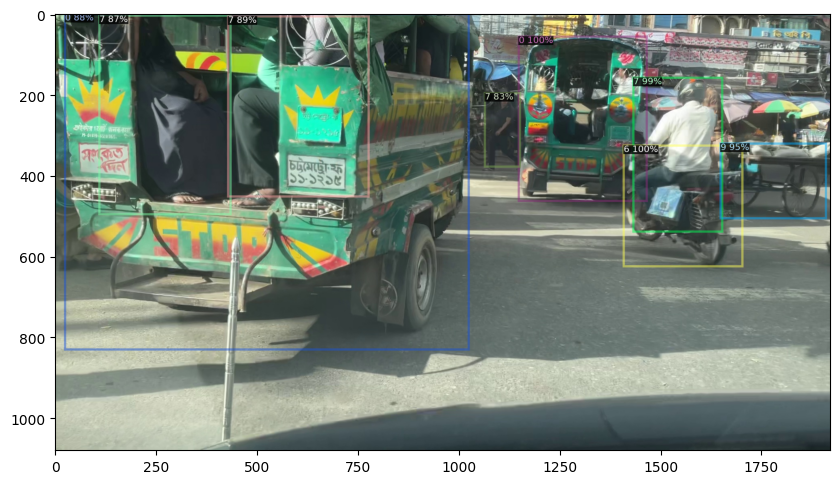

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.DEVICE = 'cuda' # cuda
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 13
cfg.MODEL.WEIGHTS = "/kaggle/working/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.75   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)

im = cv2.imread("/kaggle/input/dl-enigma-10-sust-cse-carnival-2024/dlenigma1/BadODD/images/test/chittagong_bohoddarhat1_1003.jpg")
outputs = predictor(im)
v = Visualizer(im, scale=1., instance_mode =  ColorMode.IMAGE    )

v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img = v.get_image()[:,:,[2,1,0]]
img = Image.fromarray(img)
plt.figure(figsize=(10, 10))
plt.imshow(img)

In [9]:
def get_prediction_string(boxes, scores, classes,height1, width1):
    pred_strs = []
    for i, score in enumerate(scores):
        single_pred_str = ""
        single_pred_str += str(float(classes[i])) + " " + str(float(score)) + " "
        #print(boxes[i])
        x_center , y_center, width,height = boxes[i]
        x1 = ((float(x_center) + float(width))/2)/float(width1)
        y1 = ((float(y_center) + float(height))/2)/float(height1)
        
        width = (-float(x_center) + float(width))/float(width1)
        height = (-float(y_center) + float(height))/float(height1)
        x2=float(x1)-(float(width)/2)
        y2=float(y1)-(float(height)/2)
        #single_pred_str += " ".join(str(float(x)) for x in boxes[i])
        single_pred_str +=  f"{x2} {y2} {width} {height}"
        
        pred_strs.append(single_pred_str)
    ans = ','.join(map(str, pred_strs))
    if len(ans):
        return ans
#     the solution metrics faield in case of a NaN, '' (empty). So, return "0 0 0 0 0 0" for NaN, '' (empty) string
    return "0 0 0 0 0 0"

# get the predcition in id, ImageID, PredictionString_pred foramt ...

def get_prediction_entry(i, filename, boxes, scores, classes,height1, width1):
    return {
        "id": i, # strating from 0 ...
        "ImageID": filename.split('.')[0], # before the extension ...
        "PredictionString_pred": get_prediction_string(boxes, scores, classes,height1, width1)
    }

# Directory path ...
test_directory = "/kaggle/input/dl-enigma-10-sust-cse-carnival-2024/dlenigma1/BadODD/images/test"
#test_directory = "/kaggle/input/image-test"
# Load the model ...
#model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# do the inference ...

def predict_all_files(test_directory):
    predictions = []
    for i,filename in tqdm(enumerate(os.listdir(test_directory))):
        if filename.endswith(".jpg"):
            filepath = os.path.join(test_directory, filename)
            im = cv2.imread(filepath)
            height1, width1, _ = im.shape
            
            #print(im.shape)
            results = predictor(im)
            instances = results["instances"]
            boxes_cpu = instances.pred_boxes.tensor.cpu()
            scores_cpu = instances.scores.cpu()
            classes_cpu = instances.pred_classes.cpu()

                   # Convert CPU tensors to NumPy arrays
            boxes = boxes_cpu.numpy()  # Extract bounding boxes as a numpy array
            scores = scores_cpu.numpy()  # Extract prediction scores as a numpy array
            classes = classes_cpu.numpy()
            prediction = get_prediction_entry(i, filename, boxes, scores, classes,height1, width1)
            predictions.append(prediction)
            #print(predictions[0])
            
#             to csv format ...
    predictions_df = pd.DataFrame(predictions)
    predictions_df.to_csv("submission.csv", index=False)

# call the inference function ...
predict_all_files(test_directory)

1964it [04:26,  7.38it/s]
